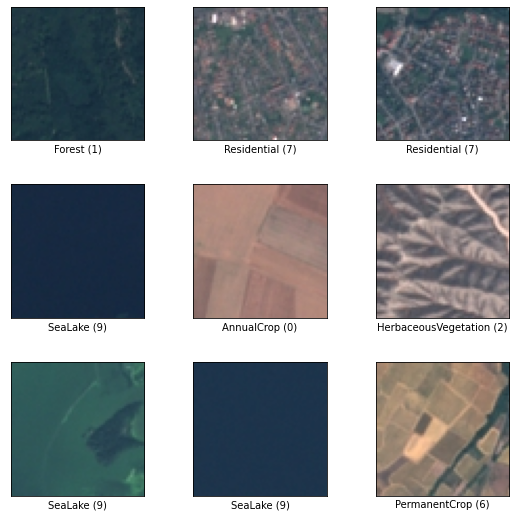

In [16]:
import tensorflow as tf  
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

DATA_DIR = "/kaggle/input/"

ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir=DATA_DIR)

tfds.show_examples(ds, ds_info);

CONSTRUCT


In [17]:
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER = int(ds_info.splits['train'].num_examples * 0.7)

ds_train, ds_valid = tfds.load('eurosat/rgb',
                               split=['train[:70%]', 'train[70%:]'],
                               data_dir=DATA_DIR,
                               as_supervised=True)

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

ds_train = (ds_train
            .map(preprocess, AUTO)
            .cache()
            .shuffle(SHUFFLE_BUFFER)
            .repeat()
            # Augmentations go here .map(augment, AUTO)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(AUTO))

ds_valid = (ds_valid
            .map(preprocess, AUTO)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

In [18]:


NUM_CLASSES = ds_info.features['label'].num_classes

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Conv2D(4, 5, padding='same', activation='elu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(8, 3, padding='same', activation='elu'),
    layers.Conv2D(8,3, padding='same', activation='elu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(72, 3, padding='same', activation='elu'),
    layers.Conv2D(72, 3, padding='same', activation='elu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(224,3,padding='same',activation='elu'),
    layers.Conv2D(224,3,padding='same',activation='elu'),
    layers.MaxPool2D(),

    
    layers.Flatten(),
    layers.Dense(64, activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='elu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [19]:
EPOCHS = 40
STEPS_PER_EPOCH = int(ds_info.splits['train'].num_examples * 0.7) // BATCH_SIZE

early_stopping = tf.keras.callbacks.EarlyStopping(patience=7, min_delta=0.001, restore_best_weights=True)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[early_stopping],
)

Epoch 1/40
1181/1181 [==============================] - 324s 269ms/step - loss: 1.8711 - sparse_categorical_accuracy: 0.3771 - val_loss: 0.9510 - val_sparse_categorical_accuracy: 0.6772
Epoch 2/40
1181/1181 [==============================] - 309s 261ms/step - loss: 1.1381 - sparse_categorical_accuracy: 0.5988 - val_loss: 0.8195 - val_sparse_categorical_accuracy: 0.7137
Epoch 3/40
1181/1181 [==============================] - 309s 262ms/step - loss: 0.9711 - sparse_categorical_accuracy: 0.6546 - val_loss: 0.7361 - val_sparse_categorical_accuracy: 0.7383
Epoch 4/40
1181/1181 [==============================] - 313s 265ms/step - loss: 0.8504 - sparse_categorical_accuracy: 0.6978 - val_loss: 0.5811 - val_sparse_categorical_accuracy: 0.7848
Epoch 5/40
1181/1181 [==============================] - 312s 264ms/step - loss: 0.7498 - sparse_categorical_accuracy: 0.7312 - val_loss: 0.5956 - val_sparse_categorical_accuracy: 0.7753
Epoch 6/40
1181/1181 [==============================] - 314s 266ms/ste

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();